In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
from ai.datamodules.text import TextDataModule
from ai.constants import REPO_DIR
from ai.misc_utils import get_vocab_size
import matplotlib.pyplot as plt
import numpy as np
import torch
import math
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass
from ai.models.nlp.transformer import Transformer
# from ai.models.nlp.transformer2 import Transformer
from torch.optim import AdamW

fname = f'{REPO_DIR}/data/shakespeare.txt'
# fname = f'{REPO_DIR}/data/names.txt'
# %load_ext autoreload
# %autoreload 2

RuntimeError: Detected that PyTorch and torchvision were compiled with different CUDA major versions. PyTorch has CUDA Version=11.8 and torchvision has CUDA Version=12.1. Please reinstall the torchvision that matches your PyTorch install.

In [ ]:
config = Transformer.Config(
    vocab_size = get_vocab_size(fname),
    block_size = 32,
    # mlp_size:int = 64
    n_embd = 128,
    n_head = 8,
    n_layer = 2,
    dropout=0
)
batch_size = 1024

In [ ]:
dm = TextDataModule.Config(fname=fname, block_size=config.block_size, batch_size=batch_size, 
                           num_workers=0).i()
dm.prepare_data()

In [ ]:
model = Transformer(config).cuda()

In [ ]:
dl = dm.train_dataloader()

In [ ]:
lr=1e-3
step=0
optim = AdamW(model.parameters(), lr=lr)

update_dists = []
for epoch in range(1):
    for X,y in iter(dl):
        X = X.cuda()
        y = y.cuda()
        step+=1
        B = X.shape[0]

        # forward
        logits, loss = model(X,y)
        
        # logits,_ = model(X)
        # loss = F.cross_entropy(logits.view(B*T,config.vocab_size), y.view(B*T))
        # logits = model(X)
        # loss = F.cross_entropy(logits.view(B*T,config.vocab_size), y.view(B*T))
        if step % 100 == 0:
            print(f'e{epoch}|s{step}: loss={loss:.5f}')
        break
        optim.zero_grad()
        loss.backward()
        optim.step()
        # for param in model.parameters():
        #     if param.grad is not None:
        #         param.data -= param.grad * lr
        with torch.no_grad():
            update_dists.append([(p.grad.std()*lr / p.data.std()).log10().detach().item() for p in optim.param_groups[0]['params']])
        if loss < 1.8 or step > 200:
            break


In [20]:
# param.grad.std()

In [16]:
for name,param in model.named_parameters():
    if param.ndim == 2:
        print(f'{name} mu={param.mean():.5f} std={param.std():.5f}')
        print(f'{name} grad={param.grad.mean():.9f} std={param.grad.std():.5f}')
        # plt.plot()


token_embedding_table.weight mu=-0.01230 std=1.01319
token_embedding_table.weight grad=0.000000000 std=0.00013
position_embedding_table.weight mu=0.01291 std=0.96615
position_embedding_table.weight grad=0.000000000 std=0.00013
blocks.0.mha.heads.q.weight mu=0.00034 std=0.07257
blocks.0.mha.heads.q.weight grad=-0.000000011 std=0.00019
blocks.0.mha.heads.k.weight mu=0.00022 std=0.07550
blocks.0.mha.heads.k.weight grad=-0.000000083 std=0.00020
blocks.0.mha.heads.v.weight mu=0.00008 std=0.06200
blocks.0.mha.heads.v.weight grad=-0.000000021 std=0.00050
blocks.0.mha.project.weight mu=-0.00011 std=0.06033
blocks.0.mha.project.weight grad=-0.000000000 std=0.00052
blocks.0.ff.layers.0.weight mu=0.00005 std=0.06122
blocks.0.ff.layers.0.weight grad=-0.000000058 std=0.00020
blocks.0.ff.layers.2.weight mu=0.00019 std=0.03376
blocks.0.ff.layers.2.weight grad=0.000000000 std=0.00039
blocks.1.mha.heads.q.weight mu=-0.00089 std=0.06915
blocks.1.mha.heads.q.weight grad=-0.000000110 std=0.00027
blocks.1.

In [19]:
# np.sqrt(1/5) == 1/np.sqrt(5)

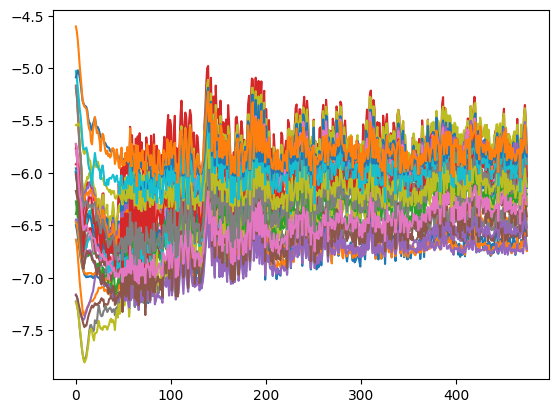

In [9]:
ud = torch.stack([torch.tensor(list(x)) for x in update_dists], 1)

fig, ax = plt.subplots()
for x in ud:
    ax.plot(x)

In [10]:
# X=X.cuda()
# result = model.generate(X[:1], 300)
# prompt = X[0]
# answer = result[0]
# print(''.join(dm.ds_train.decode(prompt)))
# print('*'*72)
# print(''.join(dm.ds_train.decode(answer)))

In [20]:
model(X)

(tensor([[ 1.0184,  6.9990,  2.2927,  ..., -2.7324,  1.4019, -2.6770],
         [-1.5447,  1.8193, -0.8833,  ..., -2.1501,  5.0578, -3.0250],
         [-1.5626, -0.8440, -1.7663,  ..., -0.9537,  4.0490, -1.8686],
         ...,
         [-3.3627, -2.5138, -4.3131,  ..., -2.3712,  2.2967, -2.1600],
         [ 8.6419,  6.4532,  0.8723,  ..., -2.7917,  0.5190, -2.5117],
         [ 1.0968,  7.2100,  1.7063,  ..., -3.0324,  2.3394, -2.4893]],
        device='cuda:0', grad_fn=<SelectBackward0>),
 None)

In [17]:
x = X[:2]
with torch.no_grad():
    idx = []
    logits,_ = model(x)
    

In [12]:
# x = X.clone()
result = []
for i in range(30):
    with torch.inference_mode():
        logits,_ = model(x)
        
    probas = torch.softmax(logits, -1)
    # greedy
    # token_ids = probas[:,-1].argmax(-1)
    token_ids = torch.multinomial(probas[:,-1], num_samples=1)
    x = x.roll(-1)
    x[:,-1] = token_ids.flatten()
    result.append(token_ids.flatten())


prompt = X[0]
answer = result[0]
print(''.join(dm.ds_train.decode(prompt)))
print('*'*72)
print(''.join(dm.ds_train.decode(answer)))

../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [143,0,0], thread: [32,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [143,0,0], thread: [33,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [143,0,0], thread: [34,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [143,0,0], thread: [35,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [143,0,0], thread: [36,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [143,0,0], thread: [37,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [143,

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
logits

In [20]:
probas.shape

torch.Size([256, 32, 65])

In [22]:
# dm.ds_train.decode(answer)